# Expressivity Analysis: Clustered vs Standard Parameterization for QAOA
#### The main aim of this notebook is to compare the expressivity of the circuit ansätze obtained for the two parametrizations.

* This notebook uses local `vectorized` as the device to run the fidelity computations to estimate the KL-dvergence measure with respect to Haar distribution as a measure of expressivity

In [125]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('custom')
from openqaoa.qaoa_parameters import PauliOp, Hamiltonian, QAOACircuitParams, create_qaoa_variational_params, QAOAVariationalStandardParams
from openqaoa.problems import Knapsack, MaximumCut, NumberPartition
from openqaoa.backends.qaoa_backend import get_qaoa_backend
from openqaoa.devices import create_device
from openqaoa.qaoalib import dicke_wavefunction, dicke_basis

from openqaoa.optimizers import get_optimizer
from qiskit import QuantumCircuit
from openqaoa.utilities import *
from tqdm import tqdm
from collections import Counter
import pandas as pd

### Problem construction
* randomly initialize (or explicitly specify) a set of numbers to be partitioned
* translate the list of numbers into the QUBO form and extract the cost Hamiltonian from it
* get the exact solution of the problem by calling the `ground_state_hamiltonian` function 
* Initialize the mixer of choice to be used in the QAOA routine

In [126]:
nums=list(np.random.randint(0,200,9))
cost_prob = NumberPartition(nums).get_qubo_problem()
cost_hamil = cost_prob.hamiltonian
n_qubits = cost_hamil.n_qubits

In [127]:
#print the solution to the problem
print(ground_state_hamiltonian(cost_hamil))

(1.0, ['110110000', '001001111'])


In [128]:
mixer_hamil_xy = XY_mixer_hamiltonian(n_qubits=cost_prob.asdict()['n'],qubit_connectivity='full')
mixer_hamil_x = X_mixer_hamiltonian(n_qubits=cost_prob.asdict()['n'])

### Construct workflow objects
* Create the QAOACircuitParams object -> responsible for the creating the abstract QAOA circuit from cost and mixer Hamiltonians
* Create and initialize the chosen Variational Parameters (for this notebook, we choose to compare Standard vs Clustered params)
* Create the backend object with prepend_states and the chosen device 

In [129]:
p=1
circuit_params = QAOACircuitParams(cost_hamil, mixer_hamil_x, p=p)

In [130]:
max_std_dev=2
variate_params_clustered = create_qaoa_variational_params(circuit_params,'clustered','rand',max_std_dev=max_std_dev)
variate_params_standard = create_qaoa_variational_params(circuit_params,'standard','ramp')

Using the sharma parametrisation
Using the sharma parametrisation


In [131]:
# k_excitations = 4
prepend_state = None#dicke_wavefunction(k_excitations,n_qubits = n_qubits)
init_hadamard = True#False

In [132]:
device = create_device('local','vectorized')
backend_obj = get_qaoa_backend(circuit_params,device,prepend_state=prepend_state,init_hadamard=init_hadamard)

### Helper functions to compute Expressivity

In [133]:
def compute_fidelity(wf1, wf2):
    """
    Given two wavefunctions wf1, wf2. Compute their fidelities
    """
    overlap1 = np.dot(np.conjugate(wf1),wf2)
    overlap2 = np.dot(np.conjugate(wf2),wf1)
    return np.real(overlap1*overlap2)

def fidelities_random_state_pairs(n_samples, variate_params, backend, seed = 4567):
    """
    Estimate # n_samples fidelity computations between randomly generated pairs of states
    for the variational parameters specified
    """
    np.random.seed(seed)
    fidelities = []
    for i in tqdm(range(n_samples)):
        random_params1 = np.random.uniform(0,2*np.pi,len(variate_params))
        random_params2 = np.random.uniform(0,2*np.pi,len(variate_params))
        
        variate_params.update_from_raw(random_params1)
        random_wf1 = backend.wavefunction(variate_params)
        
        variate_params.update_from_raw(random_params2)
        random_wf2 = backend.wavefunction(variate_params)

        fidelities.append(compute_fidelity(random_wf1,random_wf2))
    
    return fidelities

In [134]:
def haar_uniform_pdf(n_qubits, fid_vector):
    """
    Probability distribution function for Fidelity between two 
    Haar random states generated for n_qubits qubits.
    """
    N = 2**n_qubits #dimension of Hilbert Space
    pdf = [(N-1)*(1-f)**(N-2) for f in fid_vector]
    return pdf

In [136]:
n_samples=5000

In [137]:
fidelity_axis = np.linspace(0,1,n_samples)
haar_pdf = haar_uniform_pdf(9, fidelity_axis)
haar_pdf /= np.linalg.norm(haar_pdf)

In [138]:
fid_std = fidelities_random_state_pairs(n_samples, variate_params_standard, backend_obj)

100%|███████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:30<00:00, 165.01it/s]


In [139]:
fid_clustered = fidelities_random_state_pairs(n_samples, variate_params_clustered, backend_obj)

  0%|                                                                                                   | 0/5000 [00:00<?, ?it/s]/Users/vishal/opt/anaconda3/envs/openqaoa_forked_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/vishal/opt/anaconda3/envs/openqaoa_forked_env/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:57<00:00, 16.83it/s]


In [140]:
#bin the observed fidelities as histograms of probabilities and normalize
fid_std_bin_locs = np.digitize(fid_std, bins=fidelity_axis)
fid_clustered_bin_locs = np.digitize(fid_clustered, bins=fidelity_axis)

fid_std_binned = np.zeros(fidelity_axis.shape)
fid_clustered_binned = np.zeros(fidelity_axis.shape)
for i in range(len(fidelity_axis)):
    idx_std = fid_std_bin_locs[i]
    idx_clustered = fid_clustered_bin_locs[i]
    fid_std_binned[idx_std] += 1
    fid_clustered_binned[idx_clustered] += 1
    
#normalize
fid_std_binned /= np.linalg.norm(fid_std_binned)
fid_clustered_binned /= np.linalg.norm(fid_clustered_binned)

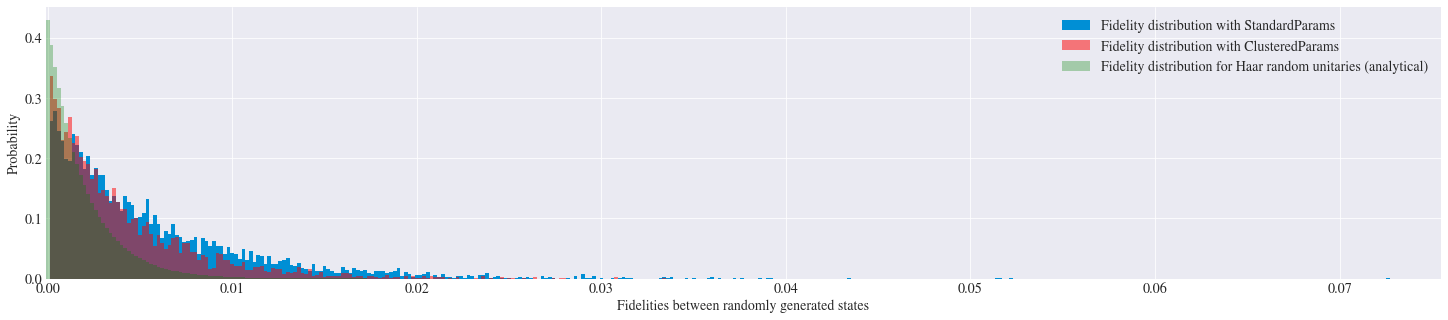

In [148]:
fig = plt.figure(figsize=(25,5))
plt.bar(fidelity_axis,fid_std_binned,width=0.0002,label='Fidelity distribution with StandardParams')
plt.bar(fidelity_axis,fid_clustered_binned,width=0.0002,color='red',alpha=0.5,label='Fidelity distribution with ClusteredParams')
plt.bar(fidelity_axis,haar_pdf,width=0.0002,color='green',alpha=0.3,label='Fidelity distribution for Haar random unitaries (analytical)')
plt.xlim(left = -0.0001, right=max([max(fid_std),max(fid_clustered)]))
plt.xlabel('Fidelities between randomly generated states')
plt.ylabel('Probability')
plt.legend();

### KL-divergence w.r.t Haar Distribution

Note, I am using Mutual Information as the similarity metric here instead of KL divergence. So the definition of expressivity is different here

In [143]:
from scipy.special import kl_div
import sklearn

In [144]:
clustered_expressivity=sklearn.metrics.mutual_info_score(haar_pdf,fid_clustered_binned)
std_expressivity=sklearn.metrics.mutual_info_score(haar_pdf,fid_std_binned)

# clustered_expressivity = kl_div(haar_pdf,fid_clustered_binned)
# std_expressivity = kl_div(haar_pdf,fid_std_binned)

print(f"Standard QAOA expressivity:{std_expressivity}",'\n',
      f"Clustered Params QAOA expressivity: {clustered_expressivity}")

Standard QAOA expressivity:0.26059472777735926 
 Clustered Params QAOA expressivity: 0.20060306607398504


/Users/vishal/opt/anaconda3/envs/openqaoa_forked_env/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/vishal/opt/anaconda3/envs/openqaoa_forked_env/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


## Expressivity w.r.t to different values of `max_std_dev` for ClusteredParams

In [145]:
max_std_dev_list=[0,2,5,10,20,50,100,200,500,1000]
variate_params_clustered_list = [create_qaoa_variational_params(circuit_params,'clustered','rand',max_std_dev=max_std_dev) for max_std_dev in max_std_dev_list]
variate_params_standard = create_qaoa_variational_params(circuit_params,'standard','ramp')

Using the sharma parametrisation
Using the sharma parametrisation
Using the sharma parametrisation
Using the sharma parametrisation
Using the sharma parametrisation
Using the sharma parametrisation
Using the sharma parametrisation
Using the sharma parametrisation
Using the sharma parametrisation
Using the sharma parametrisation
Using the sharma parametrisation
Using the sharma parametrisation
Using the sharma parametrisation
Using the sharma parametrisation
Using the sharma parametrisation
Using the sharma parametrisation
Using the sharma parametrisation
Using the sharma parametrisation
Using the sharma parametrisation
Using the sharma parametrisation


In [146]:
# k_excitations = 4
prepend_state = None#dicke_wavefunction(k_excitations,n_qubits = n_qubits)
init_hadamard = True#False

In [147]:
device = create_device('local','vectorized')
backend_obj = get_qaoa_backend(circuit_params,device,prepend_state=prepend_state,init_hadamard=init_hadamard)

In [81]:
fid_clustered_list = [fidelities_random_state_pairs(n_samples, variate_params_clustered, backend_obj) for variate_params_clustered in variate_params_clustered_list]

  0%|                                                                                  | 0/1000 [00:00<?, ?it/s]/Users/vishal/opt/anaconda3/envs/openqaoa_forked_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/vishal/opt/anaconda3/envs/openqaoa_forked_env/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:34<00:00, 29.01it/s]


In [86]:
fid_clustered_binned_list=[]
for fid_clustered in fid_clustered_list:
    fid_clustered_bin_locs = np.digitize(fid_clustered, bins=fidelity_axis)
    fid_clustered_binned = np.zeros(fidelity_axis.shape)
    for i in range(len(fidelity_axis)):
        idx_clustered = fid_clustered_bin_locs[i]
        fid_clustered_binned[idx_clustered] += 1

    #normalize
    fid_clustered_binned /= np.linalg.norm(fid_clustered_binned)
    fid_clustered_binned_list.append(fid_clustered_binned)

/Users/vishal/opt/anaconda3/envs/openqaoa_forked_env/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/vishal/opt/anaconda3/envs/openqaoa_forked_env/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/vishal/opt/anaconda3/envs/openqaoa_forked_env/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/vishal/opt/anaconda3/envs/openqaoa_forked_env/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarni

Text(0, 0.5, 'Expressivity (Lower is better)')

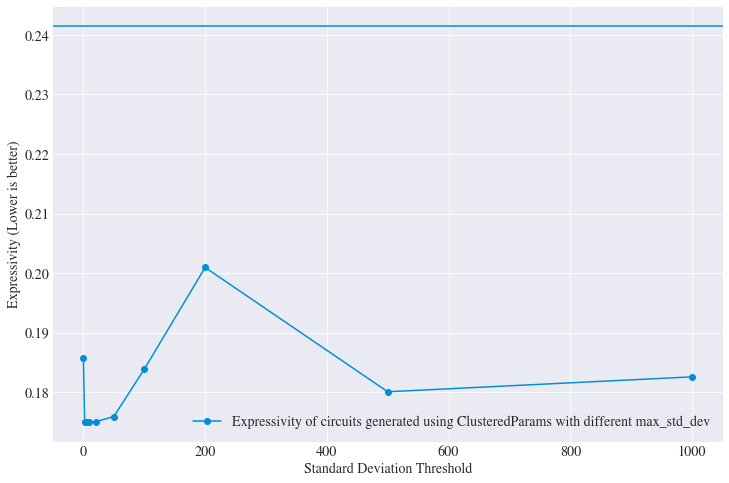

In [87]:
clustered_expressivity_list=[sklearn.metrics.mutual_info_score(haar_pdf,fid_clustered_binned) for fid_clustered_binned in fid_clustered_binned_list]
std_expressivity=sklearn.metrics.mutual_info_score(haar_pdf,fid_std_binned)

# clustered_expressivity = kl_div(haar_pdf,fid_clustered_binned)
# std_expressivity = kl_div(haar_pdf,fid_std_binned)

plt.plot(max_std_dev_list,clustered_expressivity_list,lw=1.5,marker='o',label="Expressivity of circuits generated using ClusteredParams with different max_std_dev")
plt.axhline(std_expressivity)
plt.legend();
plt.xlabel('Standard Deviation Threshold')
plt.ylabel('Expressivity (Lower is better)');

### Fairer Expressivity comparison with same number of $\gamma$ parameters between Std and Clustered

In [110]:
p19=19
p1=1
circuit_params_p19 = QAOACircuitParams(cost_hamil, mixer_hamil_x, p=p19)
circuit_params_p1 = QAOACircuitParams(cost_hamil, mixer_hamil_x, p=p1)

In [111]:
max_std_dev=2
variate_params_clustered = create_qaoa_variational_params(circuit_params_p1,'clustered','ramp',max_std_dev=max_std_dev)
variate_params_standard = create_qaoa_variational_params(circuit_params_p19,'standard','ramp')

Using the sharma parametrisation
Using the sharma parametrisation


In [123]:
variate_params_standard

Standard Parameterisation:
	p: 19
Variational Parameters:
	betas: [5.83710009 0.47827608 5.41336924 0.32272462 1.02978956 0.87217559
 0.87332952 2.26215495 6.08234161 2.62930781 0.18930319 5.41654756
 2.73665202 3.21763301 1.61082547 2.13622471 5.68467691 5.9653455
 3.52700528]
	gammas: [4.27356595 1.27580393 2.74258807 4.75142856 5.21805594 2.77433883
 0.17031709 4.70330884 1.80346781 1.46834098 0.37698696 6.11222542
 5.57113231 2.80970253 1.91779225 5.4658701  1.04545528 4.0706952
 2.43227338]

In [113]:
# k_excitations = 4
prepend_state = None#dicke_wavefunction(k_excitations,n_qubits = n_qubits)
init_hadamard = True#False

In [114]:
device = create_device('local','vectorized')
backend_obj = get_qaoa_backend(circuit_params,device,prepend_state=prepend_state,init_hadamard=init_hadamard)

In [115]:
n_samples=5000

In [116]:
fidelity_axis = np.linspace(0,1,n_samples)
haar_pdf = haar_uniform_pdf(9, fidelity_axis)
haar_pdf /= np.linalg.norm(haar_pdf)

In [117]:
fid_std = fidelities_random_state_pairs(n_samples, variate_params_standard, backend_obj)

100%|██████████████████████████████████████████████████████████████████████| 5000/5000 [00:28<00:00, 174.82it/s]


In [118]:
fid_clustered = fidelities_random_state_pairs(n_samples, variate_params_clustered, backend_obj)

  0%|                                                                                  | 0/5000 [00:00<?, ?it/s]/Users/vishal/opt/anaconda3/envs/openqaoa_forked_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/vishal/opt/anaconda3/envs/openqaoa_forked_env/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|███████████████████████████████████████████████████████████████████████| 5000/5000 [03:54<00:00, 21.32it/s]


In [119]:
#bin the observed fidelities as histograms of probabilities and normalize
fid_std_bin_locs = np.digitize(fid_std, bins=fidelity_axis)
fid_clustered_bin_locs = np.digitize(fid_clustered, bins=fidelity_axis)

fid_std_binned = np.zeros(fidelity_axis.shape)
fid_clustered_binned = np.zeros(fidelity_axis.shape)
for i in range(len(fidelity_axis)):
    idx_std = fid_std_bin_locs[i]
    idx_clustered = fid_clustered_bin_locs[i]
    fid_std_binned[idx_std] += 1
    fid_clustered_binned[idx_clustered] += 1
    
#normalize
fid_std_binned /= np.linalg.norm(fid_std_binned)
fid_clustered_binned /= np.linalg.norm(fid_clustered_binned)

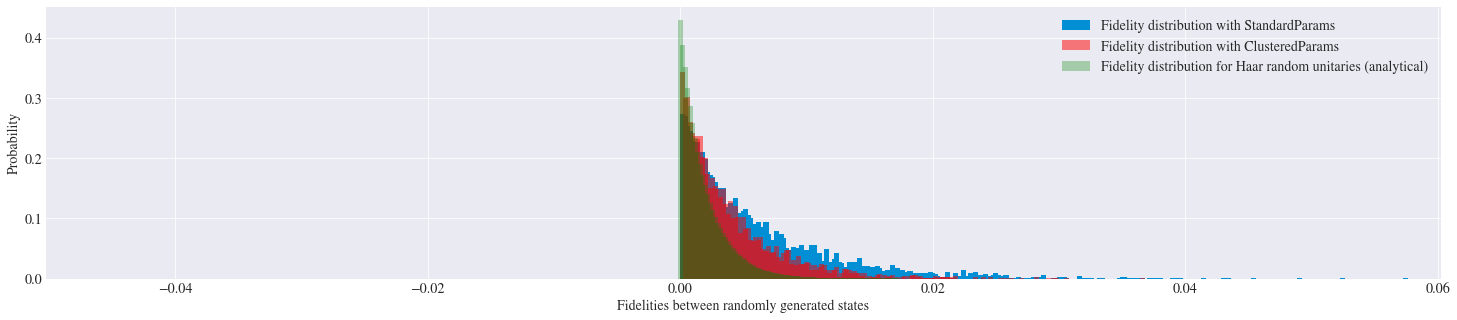

In [120]:
fig = plt.figure(figsize=(25,5))
plt.bar(fidelity_axis,fid_std_binned,width=0.0004,label='Fidelity distribution with StandardParams')
plt.bar(fidelity_axis,fid_clustered_binned,width=0.0004,color='red',alpha=0.5,label='Fidelity distribution with ClusteredParams')
plt.bar(fidelity_axis,haar_pdf,width=0.0004,color='green',alpha=0.3,label='Fidelity distribution for Haar random unitaries (analytical)')
plt.xlim(right=max([max(fid_std),max(fid_clustered)]))
plt.xlabel('Fidelities between randomly generated states')
plt.ylabel('Probability')
plt.legend();

### KL-divergence w.r.t Haar Distribution

Note, I am using Mutual Information as the similarity metric here instead of KL divergence. So the definition of expressivity is different here

In [121]:
from scipy.special import kl_div
import sklearn

In [122]:
clustered_expressivity=sklearn.metrics.mutual_info_score(haar_pdf,fid_clustered_binned)
std_expressivity=sklearn.metrics.mutual_info_score(haar_pdf,fid_std_binned)

# clustered_expressivity = kl_div(haar_pdf,fid_clustered_binned)
# std_expressivity = kl_div(haar_pdf,fid_std_binned)

print(f"Standard QAOA expressivity:{std_expressivity}",'\n',
      f"Clustered Params QAOA expressivity: {clustered_expressivity}")

Standard QAOA expressivity:0.27149427701177037 
 Clustered Params QAOA expressivity: 0.19729613650468264


/Users/vishal/opt/anaconda3/envs/openqaoa_forked_env/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/vishal/opt/anaconda3/envs/openqaoa_forked_env/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
